In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pavansekharnaidu","key":"35ffaa10173a5e5b6763d4a0d304d43f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                       title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset               📚 Students Performance Dataset 📚              66KB  2024-06-12 23:09:20          15064        313  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024         Most Streamed Spotify Songs 2024             496KB  2024-06-15 18:50:51          11347        236  1.0              
ihelon/coffee-sales                                       Coffee Sales                                  10KB  2024-07-03 20:04:43           3477         65  1.0              
thamersekhri/euro-2024-matches                            Euro 2024 Matches Stats                        8KB  2024-07-14 21:4

In [5]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:23<00:00, 59.0MB/s]
100% 1.68G/1.68G [00:23<00:00, 76.2MB/s]


In [6]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Dropout,Rescaling, Resizing, Reshape
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers  import L2, L1

In [8]:
train_directory = '/content/Dataset/Train'
test_directory = '/content/Dataset/Test'
val_directory = '/content/Dataset/Validation'

CLASS_NAMES = 'Real','Fake'


In [15]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 140002 files belonging to 2 classes.


In [16]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 10905 files belonging to 2 classes.


In [17]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99
)

Found 39428 files belonging to 2 classes.


1
0
0
0
0
1
0
1
1
0
0
1
1
1
0
1


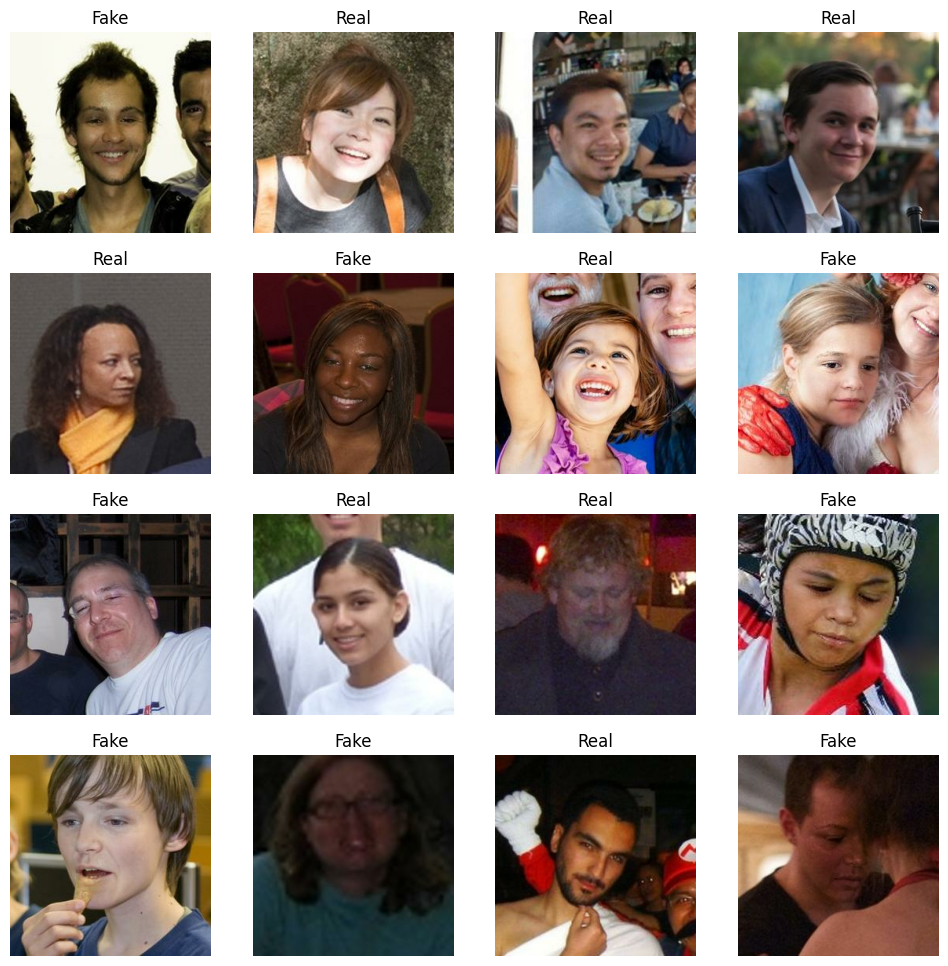

In [18]:
plt.figure (figsize=(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    print(labels[i].numpy().argmax())
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(CLASS_NAMES[labels[i].numpy().argmax()])
    plt.axis('off')

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def res_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True):
    if conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=stride)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Conv2D(filters, (kernel_size, kernel_size), padding='same', strides=stride)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_custom_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    for _ in range(3):
        x = res_block(x, 64)

    x = res_block(x, 128, stride=2, conv_shortcut=True)
    for _ in range(3):
        x = res_block(x, 128)

    x = res_block(x, 256, stride=2, conv_shortcut=True)
    for _ in range(5):
        x = res_block(x, 256)


    x = res_block(x, 512, stride=2, conv_shortcut=True)
    for _ in range(2):
        x = res_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 3)
num_classes = 2


model = build_custom_resnet(input_shape, num_classes)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset
)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_99 (Conv2D)          (None, 128, 128, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_99 (Ba  (None, 128, 128, 64)         256       ['conv2d_99[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_67 (Activation)  (None, 128, 128, 64)         0         ['batch_normalization_99

In [23]:
prediction = model.predict(test_dataset)


341/341 [==============================] - 30s 83ms/step


1/1 [==============================] - 1s 1s/step


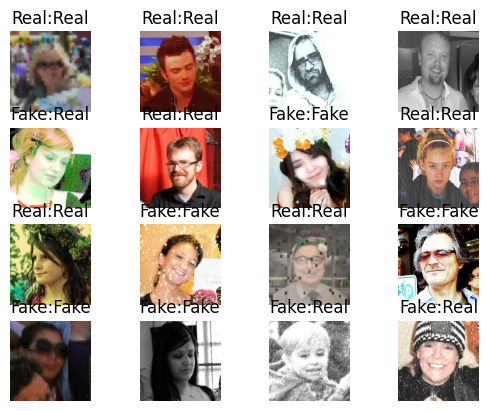

In [24]:
for image,labels in test_dataset.take(1):
    predicted = model.predict(image)

    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255.0)
        plt.title(str(CLASS_NAMES[tf.argmax(labels[i])]) + ':'+ str(CLASS_NAMES[tf.argmax(predicted[i])]))
        plt.axis('off')


plt.show()